#3D Object Detection Method - [Automated]
---------------------------
By : Juan C. Peña and Eberto Benjumea

**(Pending documentation)**

------------------------------------
# To-Do
1. Improve create_train_data function
2. Perform callbacks in training

------------------------------------
# Installing dependences

In [ ]:
!pip install deeptrack

In [ ]:
!pip install geopandas

In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import cv2
import scipy.io
%matplotlib inline
import numpy as np
import deeptrack as dt
import geopandas as gpd
import matplotlib.pyplot as plt
from skimage import img_as_float
from shapely.geometry import Point
from matplotlib.patches import Rectangle
from tensorflow.python.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler

------------------------------------
# Classes creation

In [48]:
class Preprocessor():

  def __init__(self,
               transformations,
               scales=[1, 2, 4]
               ):
    self.transformations = transformations
    self.scales = scales

  
  def crop(self, image, x, y, wide):
    cropped_image = image[y: y + wide, x: x + wide]

    return cropped_image

  def normalizate(self, image):
    normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))

    return normalized_image

  def resize(self, image, scale):
    resized_image = cv2.resize(image, (0, 0), fx=1/scale, fy=1/scale)

    return resized_image

  def generate_pipeline(self, image):
    pipeline = dt.Value(image)
    for transformation in self.transformations:
      pipeline = pipeline >> transformation

    return pipeline

  def create_train_data(self, image):
    normalized_image = self.normalizate(image)
    training_image = np.expand_dims(normalized_image, axis = -1)

    train_set = (self.generate_pipeline(training_image))
    train_set.plot()

    return train_set

  def load_images(self, data):
    dataset = [self.resize(data, scale) for scale in self.scales]
    input_set = [self.normalizate(image) for image in dataset]

    fig, ax = plt.subplots(1, len(input_set), figsize=(25,5))
    fig.tight_layout()
    fig.suptitle('Scaled 3D images')

    for index in range(len(input_set)):
      ax[index].imshow(input_set[index])
    
    return input_set

# --------------------------------------------------------------------
class Trainer():

  def __init__(self,
               train_set,
               filepath,
               model = dt.models.LodeSTAR(input_shape=(None, None, 1)),
               callbacks = [None]
               ):

    self.train_set = train_set
    self.model = model
    self.filepath = filepath
    self.callbacks = [
        ModelCheckpoint(filepath=self.filepath,
                        save_weights_only=True,
                        monitor='consistency_loss',
                        mode='min',
                        save_best_only=True
                        ),
        EarlyStopping(monitor="total_loss",
                      patience=15,
                      verbose=1,
                      mode="auto",
                      restore_best_weights=True
                      ),
        LearningRateScheduler(lambda epoch, lr: lr if epoch < 10 else lr * np.exp(-0.1))
    ]
  
  def fit(self, epochs=40, batch_size=8):
    history = self.model.fit(
        self.train_set,
        epochs = epochs,
        batch_size = batch_size,
        callbacks = self.callbacks)

    return history

  def plot_performance(self, history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
    fig.suptitle('Total loss and consistency loss')

    ax1.plot(history.history['total_loss'])
    ax1.set_title('Total loss')
    ax1.set(xlabel='epoch', ylabel='loss')
    ax1.set_ylim([0, 1.5])

    ax2.plot(history.history['consistency_loss'])
    ax2.set_title('Consitency loss')
    ax2.set(xlabel='epoch', ylabel='loss')
    ax2.set_ylim([0, 1.5])

    plt.show()

# --------------------------------------------------------------------
class Detector():

  def __init__(self,
               downsample,
               alpha = 0.1,
               cutoff = 0.998,
               mode = "quantile",
               colors = 'rgb',
               model = dt.models.LodeSTAR(input_shape=(None, None, 1)),
               ):
    self.downsample = downsample
    self.alpha = alpha
    self.cutoff = cutoff
    self.mode = mode
    self.colors = colors
    self.model = model

  def detect(self, image):
    test_set = image[np.newaxis, :, :, np.newaxis]
    test_image = test_set[:, ::self.downsample, ::self.downsample, :]

    detections = self.model.predict_and_detect(test_image, alpha=self.alpha, beta=1-self.alpha, cutoff=self.cutoff, mode=self.mode)[0]
    detections[:, 1] = detections[:, 1] * self.downsample
    detections[:, 0] = detections[:, 0] * self.downsample

    return detections

  def detect_all(self, images):
    detections = []
    fig, ax = plt.subplots(1, len(images), figsize=(25, 5))
    fig.tight_layout()
    fig.suptitle('Detections')
    
    for index in range(len(images)):
      det = self.detect(image=images[index])
      detections.append(det)

      ax[index].imshow(images[index])
      ax[index].scatter(detections[index][:, 1], detections[index][:, 0], color=self.colors[index])
      
    return detections

# --------------------------------------------------------------------
class Postprocessor():

  def __init__(self,
               wide,
               scales=[1, 2, 4],
               colors = 'rgb'
               ):
    self.wide = wide
    self.scales = scales
    self.colors = colors
  
  def scale_detections(self, detection, scale):
    scaled_detection = detection * scale

    return scaled_detection.tolist()

  def create_boxes(self, detections):
    list_detections = [Point((x,y)) for (y,x) in detections]
    points = gpd.GeoSeries(list_detections)
    boxes = points.buffer(self.wide, cap_style = 3)
    bounds = np.array([boxes[index].bounds for index in range(len(boxes))])

    return boxes, bounds

  def NMSupression(self, boxes, overlapThresh):
    # Malisiewicz et al. - non_max_suppression_fast
    if len(boxes) == 0:
      return []

    if boxes.dtype.kind == "i":
      boxes = boxes.astype("float")
    pick = []
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(y2)
 
    while len(idxs) > 0:
      last = len(idxs) - 1
      i = idxs[last]
      pick.append(i)

      xx1 = np.maximum(x1[i], x1[idxs[:last]])
      yy1 = np.maximum(y1[i], y1[idxs[:last]])
      xx2 = np.minimum(x2[i], x2[idxs[:last]])
      yy2 = np.minimum(y2[i], y2[idxs[:last]])

      w = np.maximum(0, xx2 - xx1 + 1)
      h = np.maximum(0, yy2 - yy1 + 1)

      overlap = (w * h) / area[idxs[:last]]

      idxs = np.delete(idxs, np.concatenate(([last],
        np.where(overlap > overlapThresh)[0])))
      
    return boxes[pick].astype("int")

  def apply_nms(self, image, list_bounds, overlapThresh=0.3):
    all_bounds = [bounds.tolist() for bounds in list_bounds]
    final_bounds = []

    for index in range(len(all_bounds)):
      final_bounds += all_bounds[index]

    final_bounds = np.array(final_bounds)
    final_detections = self.NMSupression(final_bounds,
                                         overlapThresh=overlapThresh)
    self.plot_results(image, final_detections)

    return final_detections


  def plot_boxes(self, test_image, detections):
    list_boxes, list_bounds, scaled_detections = [], [], []

    fig, ax = plt.subplots(figsize=(15, 15))
    plt.imshow(test_image)

    for index in range(len(detections)):
      scaled_det = self.scale_detections(detections[index], self.scales[index])
      scaled_detections.append(scaled_det)

      boxes, bounds = self.create_boxes(scaled_detections[index])
      list_boxes.append(boxes)
      list_bounds.append(bounds)

      boxes.boundary.plot(ax=ax, color = self.colors[index])

    return list_bounds

  def plot_results(self, image, boxes, color='red', lw=4):
    plt.figure(figsize=(15, 15))
    plt.imshow(image)

    wide = self.wide * 2
    for i in range(len(boxes)):
      rect = Rectangle((boxes[i][0], boxes[i][1]),wide,wide,
                       edgecolor=color,
                       facecolor='none',
                       lw=lw)
     
      plt.gca().add_patch(rect)

-------------------
# Settings

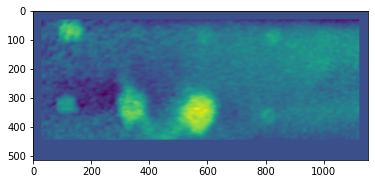

In [49]:
n = 2
train_data = scipy.io.loadmat(f'/content/drive/MyDrive/Investigacion/Data/MATLAB/output/data{n}.mat')
train_image = train_data['Spz']
plt.imshow(train_image)

In [50]:
size_object = 100
wide = 50 # size of the training template
downsample = size_object // wide

---------------
# Option A: Training

In [51]:
transformations = (
    dt.AveragePooling(ksize=(downsample, downsample, 1)),
    dt.Add(lambda: np.random.randn() * 0.1),
    dt.Gaussian(sigma=lambda:np.random.uniform(0, 0.01)), # Very sensitive
    dt.Multiply(lambda: np.random.uniform(0.6, 1.2)) # 0.3, 1.6
)

preprocessor = Preprocessor(transformations)

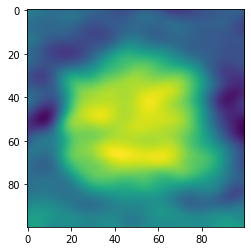

In [52]:
x, y = (65, 270)
crop = preprocessor.crop(train_image, x, y, size_object)
plt.imshow(crop)

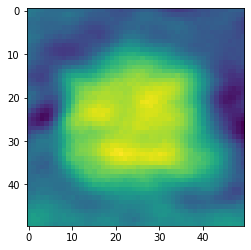

In [53]:
train_set = preprocessor.create_train_data(crop)

In [54]:
filepath = '/content/drive/MyDrive/Investigacion/Model/checkpoints/my_checkpoint'
trainer = Trainer(train_set, filepath)
history = trainer.fit(epochs=50)

Generating 164 / 160 samples before starting training
Epoch 1/50
164/164 [==============================] - 16s 21ms/step - total_loss: 3.5661 - consistency_loss: 1.6135 - lr: 0.0010
Epoch 2/50
164/164 [==============================] - 5s 30ms/step - total_loss: 1.6256 - consistency_loss: 1.1031 - lr: 0.0010  
Epoch 3/50
164/164 [==============================] - 7s 45ms/step - total_loss: 1.2260 - consistency_loss: 0.9395 - lr: 0.0010        
Epoch 4/50
164/164 [==============================] - 6s 39ms/step - total_loss: 0.9324 - consistency_loss: 0.7608 - lr: 0.0010             
Epoch 5/50
164/164 [==============================] - 7s 43ms/step - total_loss: 0.8036 - consistency_loss: 0.6962 - lr: 0.0010                   
Epoch 6/50
164/164 [==============================] - 11s 66ms/step - total_loss: 0.7800 - consistency_loss: 0.6310 - lr: 0.0010                         
Epoch 7/50
164/164 [==============================] - 11s 66ms/step - total_loss: 0.7571 - consistency_loss: 

In [49]:
# Save the weights
trainer.model.save_weights('/content/drive/MyDrive/Investigacion/Model/checkpoints/my_checkpoint')

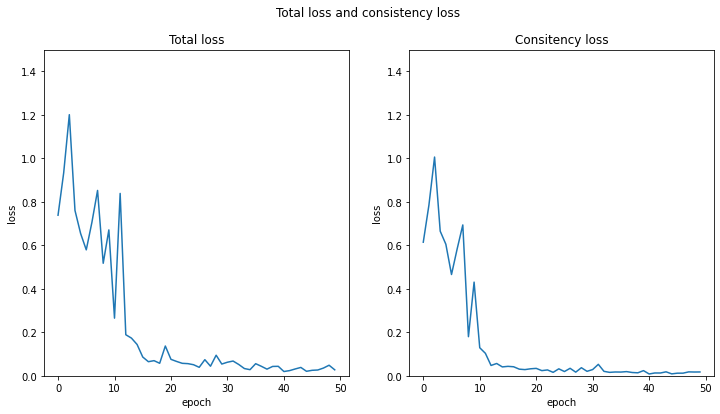

In [55]:
trainer.plot_performance(history)

------------------------------------
# Option B: Loading weights

In [51]:
trainer.model = dt.models.LodeSTAR(input_shape=(None, None, 1))
trainer.model.load_weights('/content/drive/MyDrive/Investigacion/Model/checkpoints/my_checkpoint')

-----------------
# Test

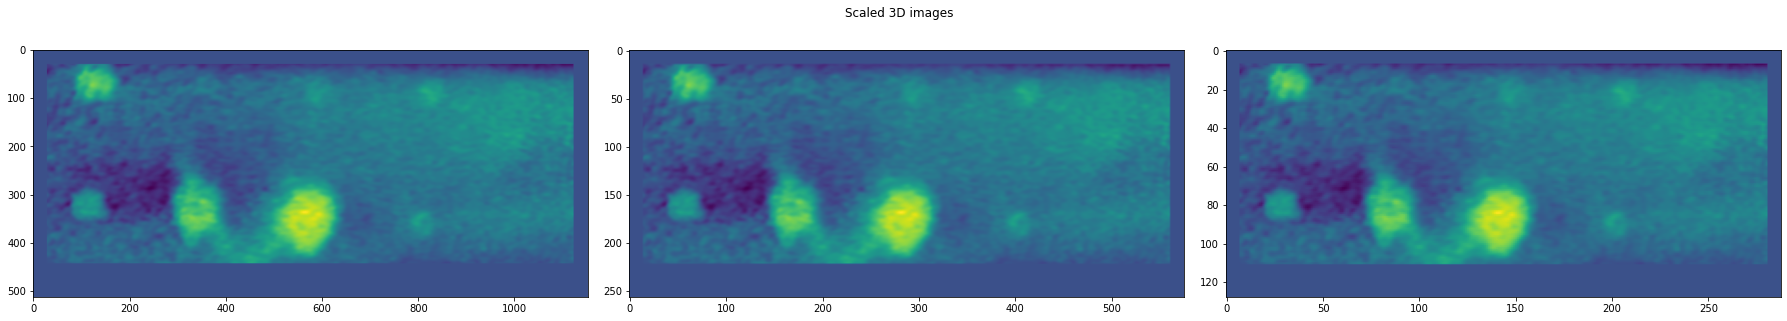

In [56]:
m = 2
test_data = scipy.io.loadmat(f'/content/drive/MyDrive/Investigacion/Data/MATLAB/output/data{m}.mat')
input_set = preprocessor.load_images(test_data['Spz'])

1/1 [==============================] - 0s 28ms/step


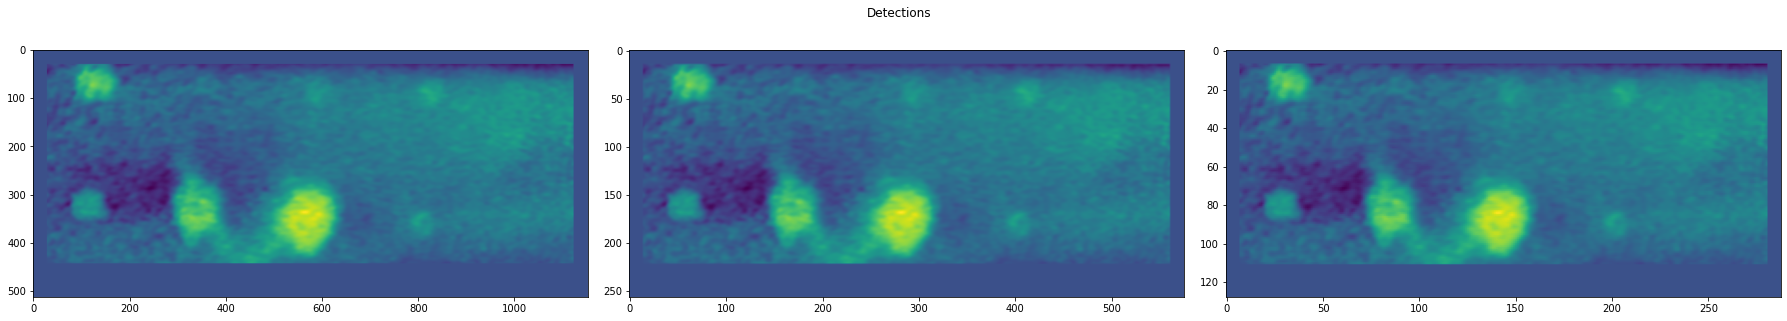

In [58]:
detector = Detector(downsample)
detections = detector.detect_all(input_set)

In [39]:
postprocessor = Postprocessor(wide)
test_image = input_set[0]

/usr/local/lib/python3.8/dist-packages/geopandas/plotting.py:402: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/geopandas/plotting.py:402: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/geopandas/plotting.py:402: UserWarning: The GeoSeries you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


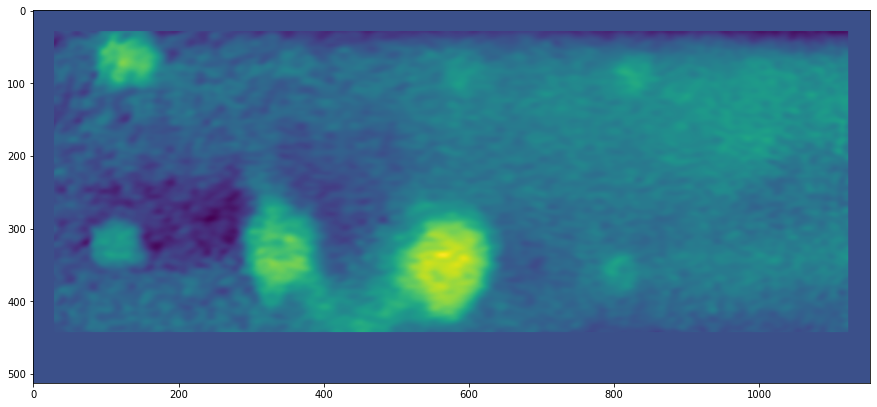

In [40]:
bounds = postprocessor.plot_boxes(test_image, detections)

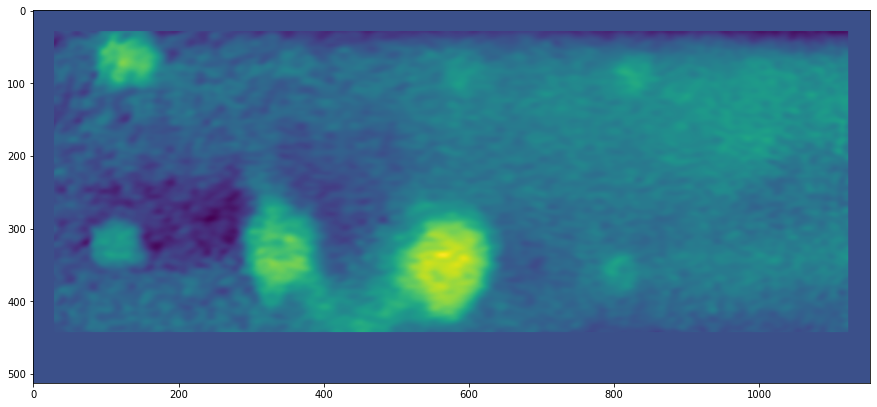

In [63]:
final_detections = postprocessor.apply_nms(test_image, bounds)

--------------------------------
# Test 2 - Using one upsampling image

In [ ]:
up_detector = Detector(wide=wide,
                    scales = [1, 2, 4], # [0.5, 1, 2]
                    downsample=downsample)

In [ ]:
dataset = cv2.resize(test_data['Spz'], (0, 0), fx=2, fy=2)

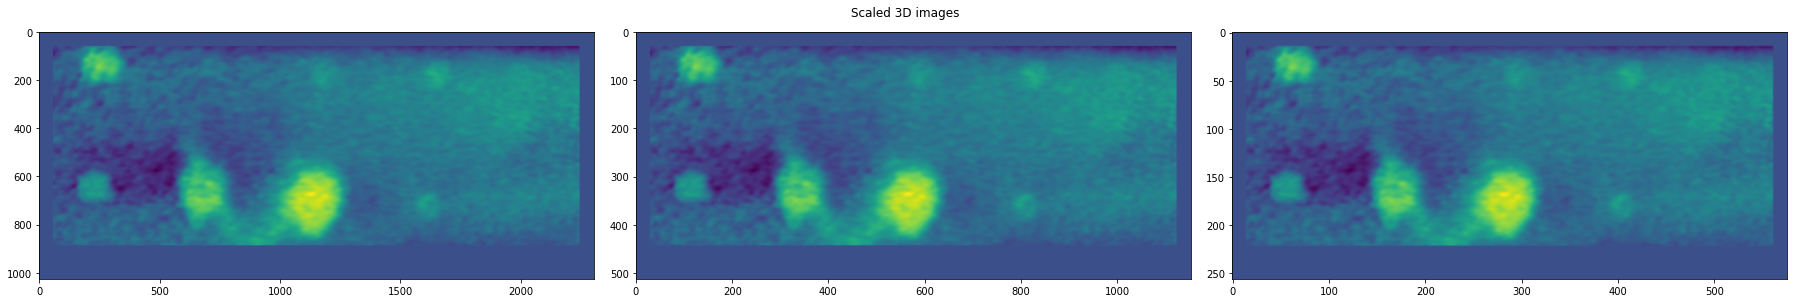

In [ ]:
up_input_set = up_detector.load_images(dataset)

In [ ]:
up_detector.model = dt.models.LodeSTAR(input_shape=(None, None, 1))
up_detector.model.load_weights('/content/drive/MyDrive/Investigacion/Model/checkpoints/my_checkpoint')

1/1 [==============================] - 0s 42ms/step


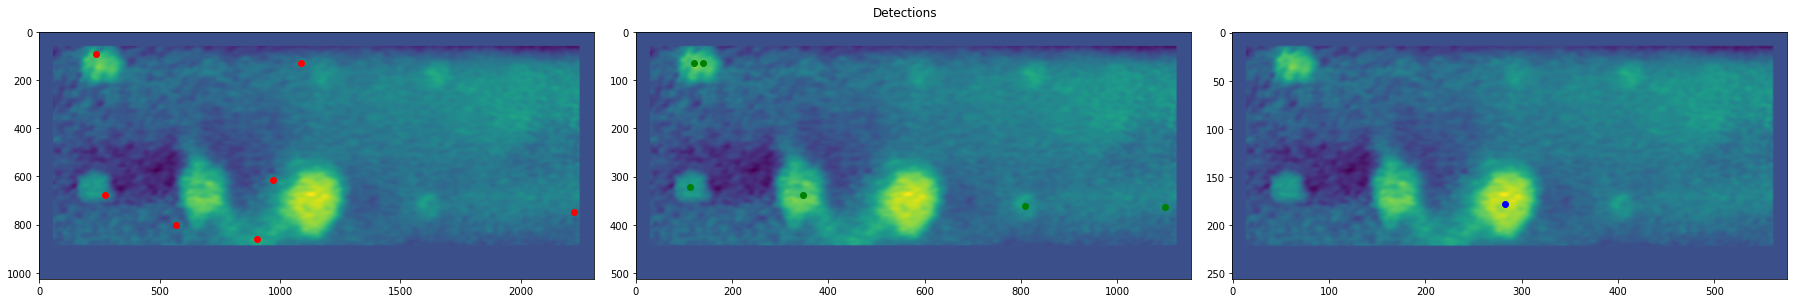

In [ ]:
up_detections = up_detector.detect_all(up_input_set)

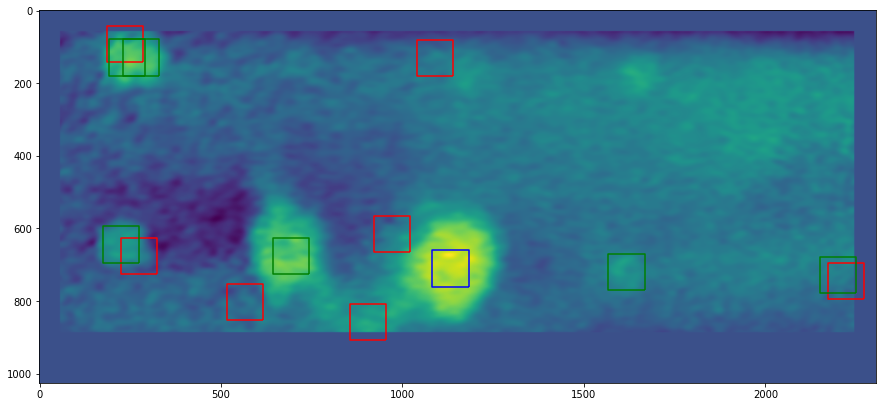

In [ ]:
up_test_image = up_input_set[0]
up_bounds = up_detector.plot_boxes(up_test_image, up_detections)

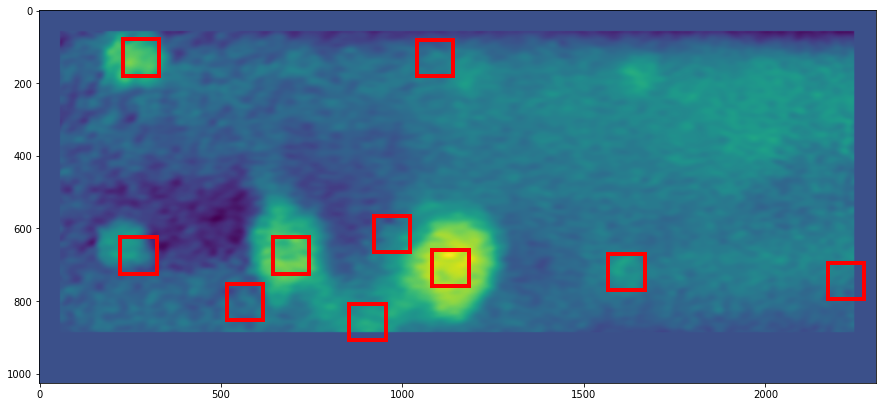

In [ ]:
up_final_detections = up_detector.apply_nms(up_test_image, up_bounds, overlapThresh=0.3)